In [1]:
import warnings
warnings.filterwarnings("ignore")

from utils import dataset, load_bow
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
import os
import numpy as np
from math import e
from scipy.stats import stats

import matplotlib.pyplot as pyp
import matplotlib as mpl
%matplotlib inline


In [2]:
w = 1

In [3]:
col = [
    'Publication Type', \
    'Venue', \
    'Author Full Names', \
    'Article Title', \
    'Abstract', \
    'Publication Date', \
    'Publication Year']

venues = dataset()[col]
venues = venues.dropna(subset=['Abstract'])
venues['Abstract Lemmatized'] = load_bow('25_venues')
venues = venues.dropna(subset=['Publication Date'])
venues['Date'] = (venues['Publication Date']+'-'+venues['Publication Year']).apply(lambda x: datetime.strptime(x, '%b-%Y'))
venues = venues.sort_values(by='Date')
venues.index = range(len(venues))

df = pd.read_csv(f'./KLD/distributions_{w}.csv')
venues['LDA Distribution'] = df['LDA Distribution']

for c in [co for co in df.columns if co[-1:] == str(w)]:
    venues[c] = df[c]

In [ ]:
# for kld in os.listdir('./KLD'):
#     df = pd.read_csv('./KLD/'+kld)
#     for c in [co for co in df.columns if co[-1:] == kld[-5]]:
#         venues[c] = df[c]*np.log2(e)

In [4]:
# matplotlib globals
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['font.family'] = 'serif'

In [5]:
centininch = 2.54
inchincent = .3937

def centtoinch(cents):
    return .3937*cents

def inchtocent(inches):
    return 2.54*inches

In [6]:
reg = venues[[f'Novelty_{w}', f'Transience_{w}', f'Resonance_{w}']]
reg = reg.dropna(subset=[f'Novelty_{w}',f'Resonance_{w}'])
NTR_df = reg[[f'Novelty_{w}', f'Transience_{w}', f'Resonance_{w}']]

In [7]:
def plot_quants_2Dhist(quants, NTR_df, ax, xbins, ybins, make_cbar=True,
                       cbar_axis=False, cbar_orientation='vertical', colorvmax=None):

    q0 = NTR_df[quants[0]]
    q1 = NTR_df[quants[1]]
    
    q0bins = xbins
    q1bins = ybins
    
    H, xedges, yedges = np.histogram2d(q0,
                                       q1,
                                       bins=[q0bins, q1bins])

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)

    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value
    
    # Plot 2D histogram using pcolor
    if colorvmax:
        usemax = colorvmax
    else:
        usemax = H.max()
    pcolm = ax.pcolormesh(xedges,yedges,Hmasked, norm=mpl.colors.LogNorm(vmin=1, vmax=usemax))
    
    if make_cbar:
        if cbar_axis:
            cbar = fig.colorbar(pcolm, cax=cbar_axis, orientation=cbar_orientation)  
        else:
            cbar = fig.colorbar(pcolm, ax=ax, orientation=cbar_orientation)
        cbar.ax.set_ylabel('counts')
    
    ax.set_xlabel(quants[0])
    ax.set_ylabel(quants[1])
    
    if make_cbar:
        return H, cbar
    else:
        return H

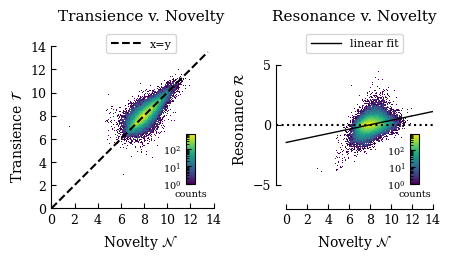

In [8]:
figsize = (centtoinch(11.4), 2.5)

fig = pyp.figure(figsize=figsize)

# Uncomment to see figure extent.
#ax = fig.add_axes([0., 0., 1., 1.])

## Plot Transience v. Novelty

ax = fig.add_axes([0.1, 0.19, 0.4, 0.72])

cbaxes = fig.add_axes([0.4, 0.29, 0.02, 0.2])

quants = [f'Novelty_{w}', f'Transience_{w}']

xbins = np.linspace(0, 14, 200)
ybins = np.linspace(0, 14, 200)

H, cbar = plot_quants_2Dhist(quants, NTR_df, ax, xbins, ybins,
                             make_cbar=True, cbar_axis=cbaxes, cbar_orientation='vertical')
cbar.ax.set_ylabel('')
cbar.ax.set_xlabel('counts', fontsize=7)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.tick_params(labelsize=7)

### Identity (x=y) line
ax.plot([0, 13.5], [0, 13.5], 'k--', linewidth=1.5)

ax.legend([mpl.lines.Line2D([0], [0], color='k', linewidth=1.5, linestyle='--')],
          ['x=y'],
          loc='upper center', fontsize=8, ncol=2, handlelength=2.7)

ax.set_ylabel('Transience $\mathcal{T}$         ')
ax.set_xlabel('Novelty $\mathcal{N}$')

ax.set_title('Transience v. Novelty')

ax.set_aspect('equal')

### Hide the right and top spines.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
### Show ticks only on the left and bottom spines.
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Limit spine range
ax.spines['left'].set_bounds( 0, 14)
ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
ax.spines['bottom'].set_bounds( 0, 14)
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])

ax.set_ylim(0, 15.5)
ax.set_xlim(0, 15.5)

## Plot Reson v. Novelty

ax = fig.add_axes([0.6, 0.19, 0.35, 0.72])

cbaxes = fig.add_axes([0.9, 0.29, 0.02, 0.2])

quants = [f'Novelty_{w}', f'Resonance_{w}']

xbins = np.linspace(0, 15, 200)
ybins = np.linspace(-7, 8, 200)

H, cbar = plot_quants_2Dhist(quants, NTR_df, ax, xbins, ybins,
                             make_cbar=True, cbar_axis=cbaxes, cbar_orientation='vertical')
cbar.ax.set_ylabel('')
cbar.ax.set_xlabel('counts', fontsize=7)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.tick_params(labelsize=7)

ax.axhline(color='k', linewidth=1.5, linestyle=':')

# plot the linear regression line ressonance ~ novelty
slope, intercept, r_value, p_value, std_err = stats.linregress(NTR_df[f'Novelty_{w}'], NTR_df[f'Resonance_{w}'])
ax.plot([0, 14], [intercept, 14*slope+intercept], '-', linewidth=1, color='black')

ax.legend([mpl.lines.Line2D([0], [0], color='k', linewidth=1, linestyle='-')],
          ['linear fit'],
          loc='upper center', fontsize=8, ncol=2, handlelength=2.7)


ax.set_xlim(-1, 14)
ax.set_ylim(-7, 8)

### Hide the right and top spines.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
### Show ticks only on the left and bottom spines.
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### Limit spine range
ax.spines['left'].set_bounds( -5, 5)
ax.set_yticks([-5, 0, 5])
ax.spines['bottom'].set_bounds( 0, 14)
ax.set_xticks([ 0, 2, 4, 6, 8, 10, 12, 14])

ax.set_ylabel('Resonance $\mathcal{R}}$')
ax.set_xlabel('Novelty $\mathcal{N}$')

_ = ax.set_title('Resonance v. Novelty')


# w Selection

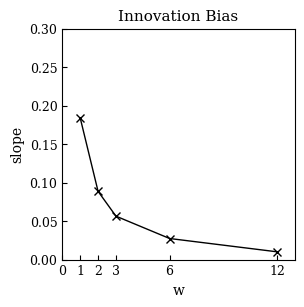

In [9]:
g = []
for i in [doc for doc in os.listdir('KLD') if doc[13]!='2']:
    w = int(i.split('_')[1].split('.')[0])
    reg = pd.read_csv('./KLD/'+i)
    reg = reg.dropna(subset=[f'Novelty_{w}',f'Resonance_{w}'])
    X = reg[f'Novelty_{w}']
    y = reg[f'Resonance_{w}']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    g.append([w, model.params[1], model.pvalues[1]])

g = pd.DataFrame(g, columns=['w', 'slope', 'pval'])
g = g.sort_values(by='w')

# plot the column 'w' in g against the column 'slope'
fig, ax = pyp.subplots(figsize=(3, 3))
ax.plot(g['w'], g['slope'], 'x-', color='black', linewidth=1)
ax.set_xlabel('w')
ax.set_ylabel('slope')
ax.set_title('Innovation Bias')
ax.set_ylim(0, 0.3)
ax.set_xlim(0, 13)
ax.set_xticks([0, 1, 2, 3, 6, 12])
pyp.show()
    

In [19]:
fix_dict = {
    'ABUALIGAH, LAITH': 'ABUALIGAH, LAITH MOHAMMAD',
    'ADAMS, RYAN P.': 'ADAMS, RYAN',
    'AGIRRE, E': 'AGIRRE, ENEKO',
    'AGIRRE, E.': 'AGIRRE, ENEKO',
    'AHUJA, N': 'AHUJA, NARENDRA',
    'AKRAM, MUHAMMAD': 'AKRAM, M. USMAN',
    'ALHAJJ, R': 'ALHAJJ, REDA',
    'ALIMI, A. M.': 'ALIMI, ADEL M.',
    'ALOIMONOS, Y': 'ALOIMONOS, YIANNIS',
    'ALSAADI, FUAD': 'ALSAADI, FUAD E.',
    'ALSAEDI, A.': 'ALSAEDI, AHMED',
    'AMARI, S': 'AMARI, SHUN-ICHI',
    'AMARI, SI': 'AMARI, SHUN-ICHI',
    'ARIK, S': 'ARIK, SABRI',
    'ASTROM, K': 'ASTROM, KALLE',
    'AVCI, E.': 'AVCI, ENGIN',
    'AVIDAN, S': 'AVIDAN, SHAI',
    'BACH, F.': 'BACH, FRANCIS R.',
    'BACH, FR': 'BACH, FRANCIS R.',
    'BACH, FRANCIS': 'BACH, FRANCIS R.',
    'BAESENS, B': 'BAESENS, BART',
    'BAGNELL, J. ANDREW': 'BAGNELL, JAMES ANDREW',
    'BAJO, J.': 'BAJO, JAVIER',
    'BALCAN, MARIA FLORINA': 'BALCAN, MARIA-FLORINA',
    'BALDWIN, T': 'BALDWIN, TIMOTHY',
    'BARANIUK, RICHARD': 'BARANIUK, RICHARD G.',
    'BARTLETT, P': 'BARTLETT, PETER L.',
    'BARTLETT, PETER': 'BARTLETT, PETER L.',
    'BARTLETT, PL': 'BARTLETT, PETER L.',
    'BARTOLI, A.': 'BARTOLI, ADRIEN',
    'BARTOLI, A': 'BARTOLI, ADRIEN',
    'BARZILAY, R': 'BARZILAY, REGINA',
    'BASRI, R': 'BASRI, RONEN',
    'BELLEMARE, MARC': 'BELLEMARE, MARC G.',
    'BELONGIE, S': 'BELONGIE, SERGE',
    'BENGIO, S': 'BENGIO, SAMY',
    'BENGIO, Y': 'BENGIO, YOSHUA',
    'BENNAMOUN, M': 'BENNAMOUN, MOHAMED',
    'BENNAMOUN, M.': 'BENNAMOUN, MOHAMED',
    'BERG, AC': 'BERG, ALEXANDER C.',
    'BERNHARD SCHÃ–LKOPF': 'BERNHARD SCHOLKOPF',
    'BERNHARD SCHOELKOPF': 'BERNHARD SCHOLKOPF',
    'BEZDEK, JC': 'BEZDEK, JAMES C.',
    'BHATTACHARYYA, C': 'BHATTACHARYYA, CHIRANJIB',
    'BI, JB': 'BI, JINBO',
    'BILMES, J': 'BILMES, JEFFREY A.',
    'BILMES, JEFF': 'BILMES, JEFFREY A.',
    'BILMES, JEFF A.': 'BILMES, JEFFREY A.',
    'BILMES, JEFFERY A.': 'BILMES, JEFFREY A.',
    'BISCHOF, H': 'BISCHOF, HORST',
    'BLACK, MICHAEL': 'BLACK, MICHAEL J.',
    'BLACK, MJ': 'BLACK, MICHAEL J.',
    'BLEI, DAVID': 'BLEI, DAVID M.',
    'BLEI, DM': 'BLEI, DAVID M.',
    'BOUGUILA, N': 'BOUGUILA, NIZAR',
    'BOULT, T. E.': 'BOULT, TERRANCE E.',
    'BOULT, TE': 'BOULT, TERRANCE E.',
    'BOULT, TERRANCE': 'BOULT, TERRANCE E.',
    'BOUTILIER, C': 'BOUTILIER, CRAIG',
    'BOYER, E': 'BOYER, EDMOND',
    'BOYKOV, Y': 'BOYKOV, YURI',
    'BREMOND, F': 'BREMOND, FRANCOIS',
    'BRONSTEIN, MICHAEL': 'BRONSTEIN, MICHAEL M.',
    'BROWN, MS': 'BROWN, MICHAEL S.',
    'BROX, T': 'BROX, THOMAS',
    'BU, JJ': 'BU, JIAJUN',
    'BUHMANN, JM': 'BUHMANN, JOACHIM M.',
    'BUSTINCE, H.': 'BUSTINCE, HUMBERTO',
    'CAI, RUI-CHU': 'CAI, RUICHU',
    'CAO, WM': 'CAO, WENMING',
    'CAPUTO, B': 'CAPUTO, BARBARA',
    'CARBONELL, JAIME': 'CARBONELL, JAIME G.',
    'CARDIE, C': 'CARDIE, CLAIRE',
    'CARIN, L': 'CARIN, LAWRENCE',
    'CARNEIRO, G': 'CARNEIRO, GUSTAVO',
    'CASTILLO, O': 'CASTILLO, OSCAR',
    'CASTILLO, O.': 'CASTILLO, OSCAR',
    'CHAI, TY': 'CHAI, TIANYOU',
    'CHAN, ANTONI': 'CHAN, ANTONI B.',
    'CHAN, CW': 'CHAN, CHRISTINE W.',
    'CHAN, F. T. S.': 'CHAN, FELIX T. S.',
    'CHAN, FTS': 'CHAN, FELIX T. S.',
    'CHANG, P. C.': 'CHANG, PEI-CHANN',
    'CHANG, PC': 'CHANG, PEI-CHANN',
    'CHATZIS, SOTIRIOS': 'CHATZIS, SOTIRIOS P.',
    'CHECHIK, G': 'CHECHIK, GAL',
    'CHELLAPPA, R': 'CHELLAPPA, RAMA',
    'CHEN, DONG-DONG': 'CHEN, DONGDONG',
    'CHEN, HUI-LING': 'CHEN, HUILING',
    'CHEN, XIN-XIN': 'CHEN, XINXIN',
    'CHOW, TWS': 'CHOW, TOMMY W. S.',
    'CHUNG, FL': 'CHUNG, FU-LAI',
    'CICHOCKI, A': 'CICHOCKI, ANDRZEJ',
    'CIPOLLA, R': 'CIPOLLA, ROBERTO',
    'COURVILLE, AC': 'COURVILLE, AARON',
    'CREMERS, D': 'CREMERS, DANIEL',
    'DANIILIDIS, K': 'DANIILIDIS, KOSTAS',
    'DARRELL, T': 'DARRELL, TREVOR',
    'DARRELL, TJ': 'DARRELL, TREVOR',
    'DAVIS, L': 'DAVIS, LARRY STEVEN',
    'DAVIS, LS': 'DAVIS, LARRY STEVEN',
    'DAVIS, LARRY' : 'DAVIS, LARRY STEVEN',
    'DAVIS, LARRY S.' : 'DAVIS, LARRY STEVEN',
    'DE LA TORRE, F': 'DE LA TORRE, FERNANDO',
    'DHILLON, INDERJIT': 'DHILLON, INDERJIT S.',
    'DING, C': 'DING, CHRIS',
    'DING, SHI-FEI': 'DING, SHIFEI',
    'EFROS, AA': 'EFROS, ALEXEI A.',
    'ER, M. J.': 'ER, MENG JOO',
    'ER, MJ': 'ER, MENG JOO',
    'FENG, W': 'FENG, WEI',
    'FERGUS, R': 'FERGUS, ROB',
    'FERRARI, V': 'FERRARI, VITTORIO',
    'FLEURET, F': 'FLEURET, FRANCOIS',
    'FORSYTH, D': 'FORSYTH, DAVID A.',
    'FORSYTH, DA': 'FORSYTH, DAVID A.',
    'FORSYTH, DAVID': 'FORSYTH, DAVID A.',
    'FREEMAN, WILLIAM': 'FREEMAN, WILLIAM T.',
    'FREEMAN, WT': 'FREEMAN, WILLIAM T.',
    'FRITZ, M': 'FRITZ, MARIO',
    'FUA, P': 'FUA, PASCAL',
    'FUA, P.': 'FUA, PASCAL',
    'FUJITA, H': 'FUJITA, HAMIDO',
    'FUJITA, H.': 'FUJITA, HAMIDO',
    'GABBOUJ, M': 'GABBOUJ, MONCEF',
    'GANDOMI, A. H.': 'GANDOMI, AMIR H.',
    'GAO, JF': 'GAO, JIANFENG',
    'GAO, JB': 'GAO, JUNBIN',
    'GAO, QX': 'GAO, QUANXUE',
    'GAO, XIN-BO': 'GAO, XINBO',
    'GHAHRAMANI, Z': 'GHAHRAMANI, ZOUBIN',
    'GIRSHICK, ROSS': 'GIRSHICK, ROSS B.',
    'GONG, MAO-GUO': 'GONG, MAOGUO',
    'GONG, SG': 'GONG, SHAOGANG',
    'GRANA, M': 'GRANA, MANUEL',
    'GRANA, M.': 'GRANA, MANUEL',
    'GRAUMAN, K': 'GRAUMAN, KRISTEN',
    'GUAN, XP': 'GUAN, XINPING',
    'HAMMER, B': 'HAMMER, BARBARA',
    'HAMMER, B.': 'HAMMER, BARBARA',
    'HANCOCK, EDWIN': 'HANCOCK, EDWIN R.',
    'HANCOCK, ER': 'HANCOCK, EDWIN R.',
    'HAO, ZHI-FENG': 'HAO, ZHIFENG',
    'HARTLEY, RICHARD': 'HARTLEY, RICHARD I.',
    'HARTLEY, RI': 'HARTLEY, RICHARD I.',
    'HARTLEY, R': 'HARTLEY, RICHARD I.',
    'HE, XF': 'HE, XIAOFEI',
    'HEBERT, M': 'HEBERT, MARTIAL',
    'HERRERA, F': 'HERRERA, FRANCISCO',
    'HERRERA, F.': 'HERRERA, FRANCISCO',
    'HERRERA-VIEDMA, E.': 'HERRERA-VIEDMA, ENRIQUE',
    'HOI, STEVEN': 'HOI, STEVEN C. H.',
    'HONG, TP': 'HONG, TZUNG-PEI',
    'HOSPEDALES, TIMOTHY': 'HOSPEDALES, TIMOTHY M.',
    'HOVY, E': 'HOVY, EDUARD',
    'HUA, CHANG-CHUN': 'HUA, CHANGCHUN',
    'HUA, G': 'HUA, GANG',
    'HUANG, GB': 'HUANG, GUANG-BIN',
    'HUANG, THOMAS': 'HUANG, THOMAS S.',
    'ILIC, S': 'ILIC, SLOBODAN',
    'JAIN, AK': 'JAIN, ANIL K.',
    'JAIN, ANIL': 'JAIN, ANIL K.',
    'JAIN, A': 'JAIN, ANIL K.',
    'JAIN, A.': 'JAIN, ANIL K.',
    'JIAO, L. C.': 'JIAO, LI-CHENG',
    'JIAO, LC': 'JIAO, LI-CHENG',
    'JORDAN, MICHAEL': 'JORDAN, MICHAEL I.',
    'JORDAN, MICHAEL I': 'JORDAN, MICHAEL I.',
    'JORDAN, MI': 'JORDAN, MICHAEL I.',
    'JUANG, CF': 'JUANG, CHIA-FENG',
    'KAHL, F': 'KAHL, FREDERIK',
    'KANADE, T': 'KANADE, TAKEO',
    'KARIMI, H. R.': 'KARIMI, AMID REZA',
    'KARIMI, HAMID': 'KARIMI, AMID REZA',
    'KHAN, FAHAD': 'KHAN, FAHAD SHAHBAZ',
    'KHOSHGOFTAAR, TAGHI': 'KHOSHGOFTAAR, TAGHI M.',
    'KHOSHGOFTAAR, TM': 'KHOSHGOFTAAR, TAGHI M.',
    'KING, I': 'KING, IRWIN',
    'KITTLER, J': 'KITTLER, JOSEF',
    'KITTLER, J.': 'KITTLER, JOSEF',
    'KITTLER, JOSEPH': 'KITTLER, JOSEF',
    'KLEIN, D': 'KLEIN, DAN',
    'KOENIG, S': 'KOENIG, SVEN',
    'KWEON, IN-SO': 'KWEON, INSO',
    'KWEON, IS': 'KWEON, INSO',
    'KWEON, IN SO': 'KWEON, INSO',
    'KWOK, JAMES T.': 'KWOK, JAMES TIN-YAU',
    'KWOK, JT': 'KWOK, JAMES TIN-YAU',
    'LAM, HAK-KEUNG': 'LAM, HAK KEUNG',
    'LAM, WAI': 'LAM, WAI Y.',
    'LAM, W': 'LAM, WAI Y.',
    'LAPATA, M': 'LAPATA, MIRELLA',
    'LAPTEV, I': 'LAPTEV, IVAN',
    'LAPTEV, I.': 'LAPTEV, IVAN',
    'LATECKI, LJ': 'LATECKI, LONGIN JAN',
    'LEIBE, B': 'LEIBE, BASTIAN',
    'LEONARDIS, A': 'LEONARDIS, ALES',
    'LEPETIT, V': 'LEPETIT, VINCENT',
    'LIAO, XF': 'LIAO, XIAOFENG',
    'LIM, C. P.': 'LIM, CHEE PENG',
    'LIM, CHEE-PENG': 'LIM, CHEE PENG',
    'LIU, XIAOPING': 'LIU, XIAOPING P.',
    'LOY, CHEN CHANGE': 'LOY, CHEN-CHANGE',
    'LUMINI, A': 'LUMINI, ALESSANDRA',
    'LYU, MICHAEL': 'LYU, MICHAEL R.',
    'MALIK, J': 'MALIK, JITENDRA',
    'MANNOR, S': 'MANNOR, SHIE',
    'MARTINEZ, L': 'MARTINEZ, LUIS',
    'MARTINEZ, L.': 'MARTINEZ, LUIS',
    'MATAS, J': 'MATAS, JIRI',
    'MATSUSHITA, Y': 'MATSUSHITA, YASUYUKI',
    'MEDIONI, G': 'MEDIONI, GERARD G.',
    'MEDIONI, GERARD': 'MEDIONI, GERARD G.',
    'MELIN, P': 'MELIN, PATRICIA',
    'MENDEL, JM': 'MENDEL, JERRY M.',
    'MESIAR, R': 'MESIAR, RADKO',
    'MESIAR, R.': 'MESIAR, RADKO',
    'METAXAS, D': 'METAXAS, DIMITRIS N.',
    'METAXAS, DIMITRIS': 'METAXAS, DIMITRIS N.',
    'MEYBODI, MR': 'MEYBODI, MOHAMMAD REZA',
    'MEYBODI, M. R.': 'MEYBODI, MOHAMMAD REZA',
    'MIAO, CY': 'MIAO, CHUNYAN',
    'MOHRI, M': 'MOHRI, MEHRYAR',
    'MORENCY, LP': 'MORENCY, LOUIS-PHILIPPE',
    'MORI, G': 'MORI, GREG',
    'MUNOS, R': 'MUNOS, REMI',
    'MURINO, V': 'MURINO, VITTORIO',
    'MURINO, V.': 'MURINO, VITTORIO',
    'NAHAVANDI, S.': 'NAHAVANDI, SAEID',
    'NANNI, L': 'NANNI, LORIS',
    'NAVAB, N': 'NAVAB, NASSIR',
    'NAYAR, K.': 'NAYAR, SHREE K.',
    'NAYAR, SHREE': 'NAYAR, SHREE K.',
    'NAYAR, SK': 'NAYAR, SHREE K.',
    'NEVATIA, R': 'NEVATIA, RAMAKANT',
    'NEVATIA, RAMA': 'NEVATIA, RAMAKANT',
    'NG, WWY': 'NG, WING W. Y.',
    'NI, B': 'NI, BINGBING',
    'NIU, B.': 'NIU, BEN',
    'OH, SK': 'OH, SUNG-KWUN',
    'PAJDLA, T': 'PAJDLA, TOMAS',
    'PANG, YAN-WEI': 'PANG, YANWEI',
    'PANTIC, M': 'PANTIC, MAJA',
    'PARAGIOS, N': 'PARAGIOS, NIKOS',
    'PEDRYCZ, W': 'PEDRYCZ, WITOLD',
    'PEDRYCZ, W.': 'PEDRYCZ, WITOLD',
    'PEREZ, P': 'PEREZ, PATRICK',
    'PERONA, P': 'PERONA, PIETRO',
    'PINEAU, J': 'PINEAU, JOELLE',
    'POLLEFEYS, M': 'POLLEFEYS, MARC',
    'PONCE, J': 'PONCE, JEAN',
    'PONCE, J.': 'PONCE, JEAN',
    'PRECUP, D': 'PRECUP, DOINA',
    'PRINCIPE, J. C.': 'PRINCIPE, JOSE C.',
    'PRINCIPE, JC': 'PRINCIPE, JOSE C.',
    'PRINCIPE, JOSE': 'PRINCIPE, JOSE C.',
    'QIAN, YU-HUA': 'QIAN, YUHUA',
    'QIAO, H': 'QIAO, HONG',
    'QIAO, JUN-FEI': 'QIAO, JUNFEI',
    'QUAN, L': 'QUAN, LONG',
    'RAKKIYAPPAN, RAJAN': 'RAKKIYAPPAN, R.',
    'RAMAMOORTHI, R': 'RAMAMOORTHI, RAVI',
    'RAMANAN, D': 'RAMANAN, DEVA',
    'REHG, JM': 'REHG, JAMES M.',
    'REID, I': 'REID, IAN',
    'REID, I. D.': 'REID, IAN',
    'ROTH, D': 'ROTH, DAN',
    'ROTH, S': 'ROTH, STEFAN',
    'ROTHER, C': 'ROTHER, CARSTEN',
    'SAMARAS, D': 'SAMARAS, DIMITRIS',
    'SAPIRO, G': 'SAPIRO, GUILLERMO',
    'SATO, I': 'SATO, IMARI',
    'SATO, Y': 'SATO, YOICHI',
    'SAVARESE, S': 'SAVARESE, SILVIO',
    'SCHIELE, B': 'SCHIELE, BERNT',
    'SCHIELE, B.': 'SCHIELE, BERNT',
    'SCHMID, C': 'SCHMID, CORDELIA',
    'SCHMID, C.': 'SCHMID, CORDELIA',
    'SCHUURMANS, D': 'SCHUURMANS, DALE',
    'SCLAROFF, S': 'SCLAROFF, STAN',
    'SEBE, N': 'SEBE, NICU',
    'SHAH, M': 'SHAH, MUBARAK',
    'SHAH, M.': 'SHAH, MUBARAK',
    'SHAO, YUAN-HAI': 'SHAO, YUANHAI',
    'SHEN, DG': 'SHEN, DINGGANG',
    'SHEN, Q': 'SHEN, QIANG',
    'SHI, L': 'SHI, LEI',
    'SHI, L.': 'SHI, LEI',
    'SHI, P': 'SHI, PENG',
    'SIGAL, L': 'SIGAL, LEONID',
    'SIVIC, J': 'SIVIC, JOSEF',
    'SMINCHISESCU, C': 'SMINCHISESCU, CRISTIAN',
}